In [45]:
import pickle
import itertools
import numpy as np
from tqdm.notebook import tqdm
from multiprocessing import Pool
import sacrebleu
import pandas as pd
import json
import seaborn as sns
sns.set()

In [2]:
wmt_scored = pickle.load(open('wmt16-19_toen_scored.pkl', 'rb'))
wmt_scored.head(1)

,lp,HITId,WorkerId,score,time,system,type,sid,reference,source,...,chrf:statistics_10,chrf:statistics_11,chrf:statistics_12,chrf:statistics_13,chrf:statistics_14,chrf:statistics_15,chrf:statistics_16,chrf:statistics_17,bert_score:f1,bleurt_score
0,de-en,3QQUBC64ZEEFIPT2SKINDZZTZ3SNXN,A0077,78,2052.0,online-G,SYSTEM,1906,Rather than having an executive make the annou...,Anstatt einen Manager die Ankündigung machen z...,...,151,95,145,150,85,144,149,76,0.941347,-0.00404


In [3]:
wmt_scored.type.value_counts()

SYSTEM    585386
REPEAT     75998
Name: type, dtype: int64

In [4]:
true_means = wmt_scored.groupby(['year','lp', 'system'])[['score']].mean()
true_means

score
year lp    system                   
2016 cs-en PJATK           69.001067
           cu-mergedtrees  56.020474
           jhu-pbmt        72.411999
           online-A        69.633523
           online-B        70.983888
...                              ...
2019 zh-en online-A.0      75.306259
           online-B.0      80.686373
           online-G.0      72.351598
           online-X.0      66.889482
           online-Y.0      78.002909

[261 rows x 1 columns]

In [5]:
def pairs(x):
    for (year, lp), group in x.groupby(['year', 'lp']):
        systems = group.system.unique()
        
        for i, j in itertools.combinations(systems, 2):
            yield (year, lp), i, j
            
all_pairs = list(pairs(wmt_scored))
pairs_2019 = list(pairs(wmt_scored[wmt_scored.year == 2019]))
print(len(all_pairs))
print(all_pairs[-1])

def get_preds(all_pairs, scores, only_2019=False):
    if only_2019:
        all_pairs = pairs_2019
    
    preds = np.zeros(len(all_pairs))
    if type(scores) == type({}):
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores[year, lp, i] - scores[year, lp, j] > 0 else 0
    else:
        for ii, ((year, lp), i, j) in enumerate(all_pairs):
            preds[ii] = 1 if scores.loc[year, lp, i] - scores.loc[year, lp, j] > 0 else 0
            
    return preds

true_preds = get_preds(all_pairs, true_means['score'])

1324
((2019, 'zh-en'), 'online-X.0', 'MSRA.MASS.6942')


In [6]:
# BLEU
def bleu_agg(x):
    cols = [ ('bleu:counts_%d' % i) for i in range(0, 4) ] + [ ('bleu:totals_%d' % i) for i in range(0, 4) ]
    cols += ['bleu:sys_len', 'bleu:ref_len']
    aggs = x[cols].sum()

    totals = [ aggs['bleu:totals_%d' % i] for i in range(0, 4) ]
    counts = [ aggs['bleu:counts_%d' % i] for i in range(0, 4) ]
    ref_len = aggs['bleu:ref_len']
    sys_len = aggs['bleu:sys_len']

    return sacrebleu.compute_bleu(counts, totals, sys_len, ref_len).score

# TER
def ter_agg(x):
    cols = [ 'ter:num_edits', 'ter:ref_length' ]
    aggs = x[cols].sum()

    num_edits = aggs['ter:num_edits']
    ref_length = aggs['ter:ref_length']

    # for one reference
    return -num_edits / ref_length


# chrf
def chrf_agg(x):
    cols = [ ('chrf:statistics_%d' % i) for i in range(0, 18) ]
    aggs = x[cols].sum()

    statistics = [ aggs['chrf:statistics_%d' % i] for i in range(0, 18) ]

    return sacrebleu.CHRF.compute_chrf(statistics, order=6, beta=2).score

def bert_score_agg(x):
    return x['bert_score:f1'].mean()

def bleurt_agg(x):
    return x['bleurt_score'].mean()

def human_agg(x):
    return x['score'].mean()

In [7]:
# taken from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_decomposition(metric_results, true_preds):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    avg_expected_loss = (true_preds != metric_results).mean()

    avg_bias = (main_predictions != true_preds).mean()

    signs = (main_predictions == true_preds).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias, avg_var_contrib

# adopted from https://github.com/rasbt/mlxtend/blob/master/mlxtend/evaluate/bias_variance_decomp.py
def bias_var_noise_decomposition(metric_results, human_results, true_preds, no_bias=False):
    main_predictions = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x)),
                                           axis=0,
                                           arr=metric_results)

    optimal_predictions = np.apply_along_axis(lambda x:
                                       np.argmax(np.bincount(x)),
                                       axis=0,
                                       arr=human_results)
    
    if no_bias:
        main_predictions = optimal_predictions
    true_preds = optimal_predictions
    
    avg_expected_loss = (human_results != metric_results).mean()

    noises = (human_results != true_preds).mean(axis=0)
    probs = (metric_results == true_preds).mean(axis=0)

    avg_noise_contrib = ((2 * probs - 1) * noises).mean()

    avg_bias = (main_predictions != true_preds).mean()

    signs = (main_predictions == true_preds).astype(np.int64) * 2 - 1
    variances = (metric_results != main_predictions).mean(axis=0)
    avg_var_contrib = (signs * variances).mean()

    return avg_expected_loss, avg_bias, avg_var_contrib, avg_noise_contrib

In [21]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(metric):
    groups = [ g.sample(frac=1, replace=True) for i, g in cached ]
    observed_means = [ g['score'].mean() for g in groups ]
    
    d = { label:mean for label, mean in zip(labels, observed_means) }
    return get_preds(all_pairs, d)

with Pool(12) as p:
    it = tqdm(p.imap_unordered(f, [None]*1000, chunksize=100), total=1000)
    output = list(it)
    human_results = np.array(output, dtype=np.int64)
    
# optimal predictions
optimal_predictions = np.apply_along_axis(lambda x:
                                   np.argmax(np.bincount(x)),
                                   axis=0,
                                   arr=human_results)

optimal_predictions

array([0, 1, 1, ..., 1, 0, 0])

In [52]:
cached = [ (i, pd.DataFrame(g)) for i, g in wmt_scored.groupby(['year', 'lp', 'system']) ]
labels = [ i[0] for i in cached ]

def f(metric):    
    # get agg function
    agg = globals()['%s_agg' % metric]
        
    groups = [ g.sample(frac=1, replace=True) for i, g in cached ]
    agg_means = [ agg(g) for g in groups ]
    agg_means = { label:mean for label, mean in zip(labels, agg_means) }

    flag = metric == 'bleurt'
    return get_preds(all_pairs, agg_means, only_2019=flag)

WORKERS = 12
NUM_TRIALS = 1000
CHUNKSIZE = int(NUM_TRIALS / WORKERS / 10)
metrics = ['bert_score']
results = {}

with Pool(WORKERS) as p:
    for metric in tqdm(metrics):
        it = tqdm(p.imap_unordered(f, [metric]*NUM_TRIALS, chunksize=CHUNKSIZE), total=NUM_TRIALS)
        output = list(it)
        metric_results = np.array(output, dtype=np.int64)

In [53]:
xy = pd.DataFrame(list(zip(human_results.mean(axis=0), metric_results.mean(axis=0))))
xy.columns = ['human_prob', 'metric_prob']

xy['human_prob_diff'] = np.abs(xy['human_prob'] - 0.5)
xy['metric_prob_diff'] = np.abs(xy['metric_prob'] - 0.5)
xy

,human_prob,metric_prob,human_prob_diff,metric_prob_diff
0,0.00,0.000,0.50,0.500
1,0.99,1.000,0.49,0.500
2,0.96,1.000,0.46,0.500
3,0.03,0.012,0.47,0.488
4,1.00,1.000,0.50,0.500
...,...,...,...,...
1319,1.00,1.000,0.50,0.500
1320,0.01,0.481,0.49,0.019
1321,1.00,0.977,0.50,0.477
1322,0.00,0.000,0.50,0.500


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='human_prob_diff', ylabel='metric_prob_diff'>

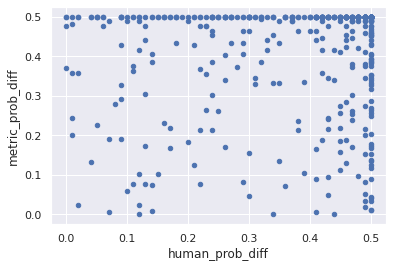

In [54]:
xy.plot.scatter(x='human_prob_diff', y='metric_prob_diff')